# 📘 Machine Learning Model for Failure Type Classification
This notebook implements and compares multiple machine learning models to classify failure types based on extracted features. Improvements include preprocessing, feature scaling, hyperparameter tuning, and model evaluation enhancements.

In [5]:
# Install required packages (if not already installed)
%pip install scikit-learn
%pip install pyarrow
%pip install imbalanced-learn

# Import Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn modules
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.impute import SimpleImputer, KNNImputer

# Imbalanced-learn for SMOTE
from imblearn.over_sampling import SMOTE

# Utility
import joblib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# 1. Load Data

In [6]:
# Load and preview dataset
df = pd.read_csv('aligned_segment_features.csv')
df = df.drop(columns=['FileName', 'Segment'])

df.head()

,CurrentU_RMS,CurrentU_Peak,CurrentU_Skew,CurrentU_Kurt,PhaseDiff_UV,PhaseDiff_VW,PhaseDiff_WU,NegSeqCurrent,FFT_U_MaxAmp,FFT_U_DomFreq,THD_U,TempA_Mean,FailureType,Vib_RMS,Vib_Crest,Vib_Kurt,FFT_Vib_MaxAmp,FFT_Vib_DomFreq
0,2.320037,4.428752,-0.001090,1.506825,0.126290,-0.121931,-0.004358,1.520541,83172.98549,48.5,0.140021,27.620829,BPFI,9.060076,7.753160,11.619405,54204.80811,7479.0
1,2.314846,4.501437,-0.000305,1.506516,0.131929,-0.127583,-0.004346,1.516821,82987.67194,48.5,0.139847,27.654476,BPFI,9.106352,7.742930,11.378550,56554.17796,7479.0
2,2.311214,4.404067,0.000810,1.505886,0.130188,-0.121670,-0.008518,1.514569,82861.18342,48.5,0.139457,27.680961,BPFI,9.148473,7.479943,11.243382,66337.57248,2198.5
3,2.314929,4.432866,0.001115,1.506565,0.139776,-0.130388,-0.009388,1.516916,82989.66836,48.5,0.139686,27.705482,BPFI,9.341748,7.636660,11.407377,79036.72586,2198.0
4,2.317392,4.471266,0.000610,1.506986,0.131821,-0.125079,-0.006742,1.519293,83078.58226,48.5,0.139827,27.729335,BPFI,9.270608,7.722877,10.954823,69920.15273,2198.0


# 2. Explore Class Distribution

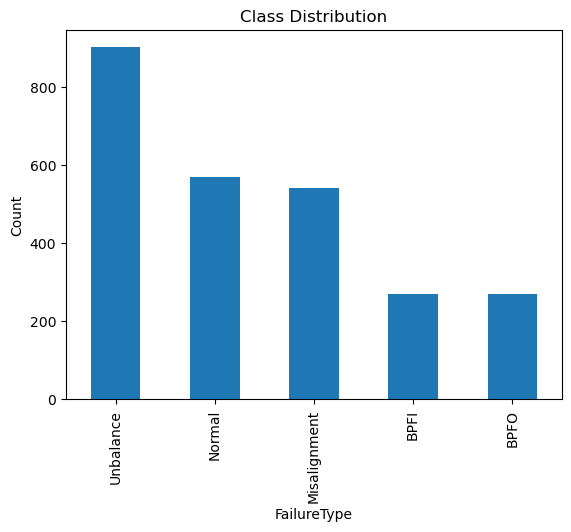

In [7]:
df['FailureType'].value_counts().plot(kind='bar', title='Class Distribution')
plt.ylabel('Count')
plt.show()

# 3.Preprocess & clean
## Imputation

In [8]:
from sklearn.impute import SimpleImputer, KNNImputer

# Compare different imputation strategies on df
imputation_results = {}

numeric_cols = df.select_dtypes(include = ['number']).columns
categorial_cols = df.select_dtypes(exclude = ['number']).columns

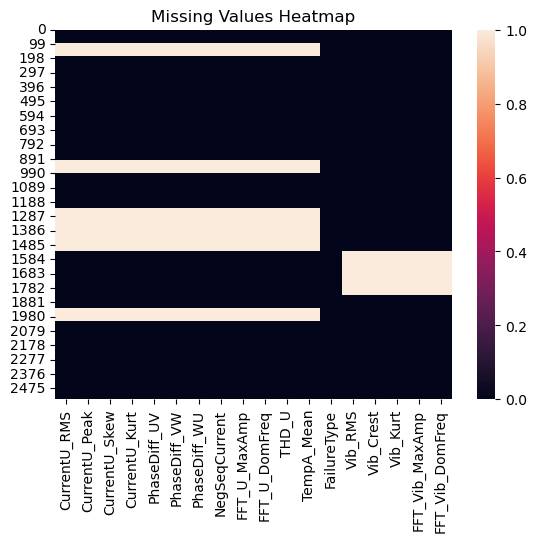

In [9]:
sns.heatmap(df.isnull())
plt.title('Missing Values Heatmap')
plt.show()

In [10]:
# 1. Fill NaN with 0
df_zero = df.fillna(0)
imputation_results['zero'] = df_zero

In [11]:
# 2. Fill NaN with mean

mean_imputer = SimpleImputer(strategy = 'mean')
df_mean_imputed = pd.DataFrame(mean_imputer.fit_transform(df[numeric_cols]), columns = numeric_cols)
df_mean = pd.concat([df_mean_imputed, df[categorial_cols].reset_index(drop=True)], axis = 1)

imputation_results['mean'] = df_mean

In [12]:
# 3. Fill NaN with median
df_median_imputed = pd.DataFrame(mean_imputer.fit_transform(df[numeric_cols]), columns = numeric_cols)
df_median = pd.concat([df_median_imputed, df[categorial_cols].reset_index(drop=True)], axis = 1)
imputation_results['median'] = df_median


In [13]:

# 4. KNN imputation (k-fold style imputation)
knn_imputer = KNNImputer(n_neighbors=5)
df_knn = pd.DataFrame(knn_imputer.fit_transform(df[numeric_cols]), columns = numeric_cols)
imputation_results['knn'] = df_knn



In [14]:
# Show how many NaNs remain after each method
for method, imputed_df in imputation_results.items():
    print(f"{method} imputation - Remaining NaNs:\n{imputed_df.isnull().sum()}\n")

zero imputation - Remaining NaNs:
CurrentU_RMS       0
CurrentU_Peak      0
CurrentU_Skew      0
CurrentU_Kurt      0
PhaseDiff_UV       0
PhaseDiff_VW       0
PhaseDiff_WU       0
NegSeqCurrent      0
FFT_U_MaxAmp       0
FFT_U_DomFreq      0
THD_U              0
TempA_Mean         0
FailureType        0
Vib_RMS            0
Vib_Crest          0
Vib_Kurt           0
FFT_Vib_MaxAmp     0
FFT_Vib_DomFreq    0
dtype: int64

mean imputation - Remaining NaNs:
CurrentU_RMS       0
CurrentU_Peak      0
CurrentU_Skew      0
CurrentU_Kurt      0
PhaseDiff_UV       0
PhaseDiff_VW       0
PhaseDiff_WU       0
NegSeqCurrent      0
FFT_U_MaxAmp       0
FFT_U_DomFreq      0
THD_U              0
TempA_Mean         0
Vib_RMS            0
Vib_Crest          0
Vib_Kurt           0
FFT_Vib_MaxAmp     0
FFT_Vib_DomFreq    0
FailureType        0
dtype: int64

median imputation - Remaining NaNs:
CurrentU_RMS       0
CurrentU_Peak      0
CurrentU_Skew      0
CurrentU_Kurt      0
PhaseDiff_UV       0
PhaseDi

<Axes: >

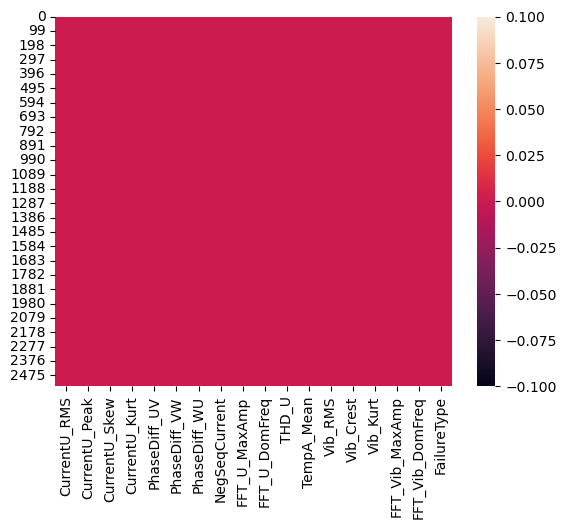

In [15]:
sns.heatmap(df_mean.isnull())

# 4. Feature Engineering
- ❗ Add explanation that features were pre-extracted using MATLAB (time, frequency, statistical).
- Consider inserting a feature summary table here.

In [18]:
# Feature summary
df.describe().T[['mean', 'std', 'min', 'max']].style.background_gradient(cmap='Blues')

,mean,std,min,max
CurrentU_RMS,2.436775,0.203206,2.190413,2.750285
CurrentU_Peak,4.652143,0.379340,3.668988,5.579369
CurrentU_Skew,0.002172,0.002945,-0.004524,0.013794
CurrentU_Kurt,1.520306,0.012510,1.503235,1.538612
PhaseDiff_UV,0.113406,0.010820,0.077106,0.140111
PhaseDiff_VW,-0.114565,0.010904,-0.136489,-0.079778
PhaseDiff_WU,0.001159,0.007474,-0.027117,0.033760
NegSeqCurrent,1.593402,0.131511,1.430081,1.796749
FFT_U_MaxAmp,82365.418479,8791.361347,63820.516470,98880.778450
FFT_U_DomFreq,48.553030,0.153996,48.500000,49.000000


# 5. SMOTE

In [19]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

# 6. SMOTE
smote_results = {}
sm = SMOTE(random_state=42)
for key, X_imp in imputation_results.items():
    X = X_imp.copy()
    if 'FailureType' not in X.columns:
        X['FailureType'] = df['FailureType'].reset_index(drop=True)
    y = X['FailureType'].reset_index(drop=True)
    X = X.drop(columns=['FailureType'])
    # Encode non-numeric columns
    non_numeric_cols = X.select_dtypes(include=['object']).columns
    for col in non_numeric_cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
    X_resampled, y_resampled = sm.fit_resample(X, y)
    df_smoted = pd.DataFrame(X_resampled, columns=X.columns)
    df_smoted['FailureType'] = y_resampled
    smote_results[key] = df_smoted


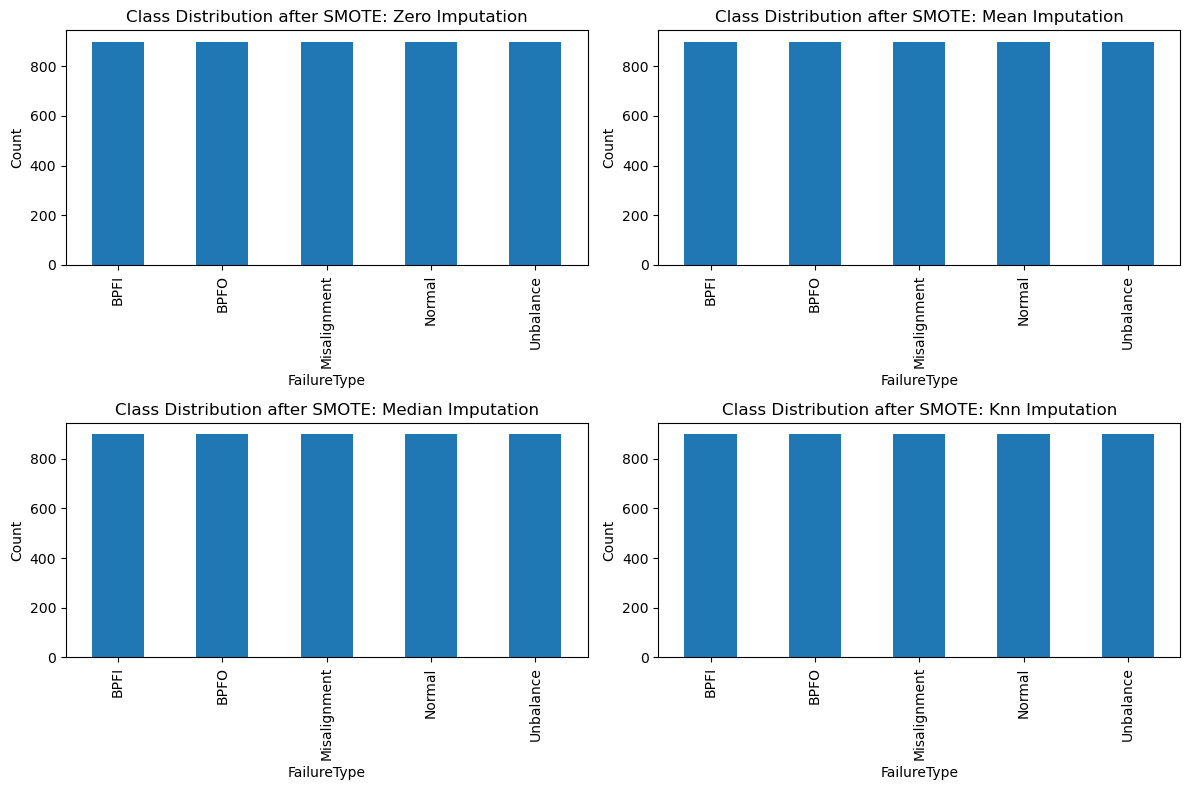

In [20]:
# Plot class distribution after SMOTE for each imputation method
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()
for i, (key, df_smoted) in enumerate(smote_results.items()):
    df_smoted['FailureType'].value_counts().plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Class Distribution after SMOTE: {key.capitalize()} Imputation')
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel('FailureType')
plt.tight_layout()
plt.show()

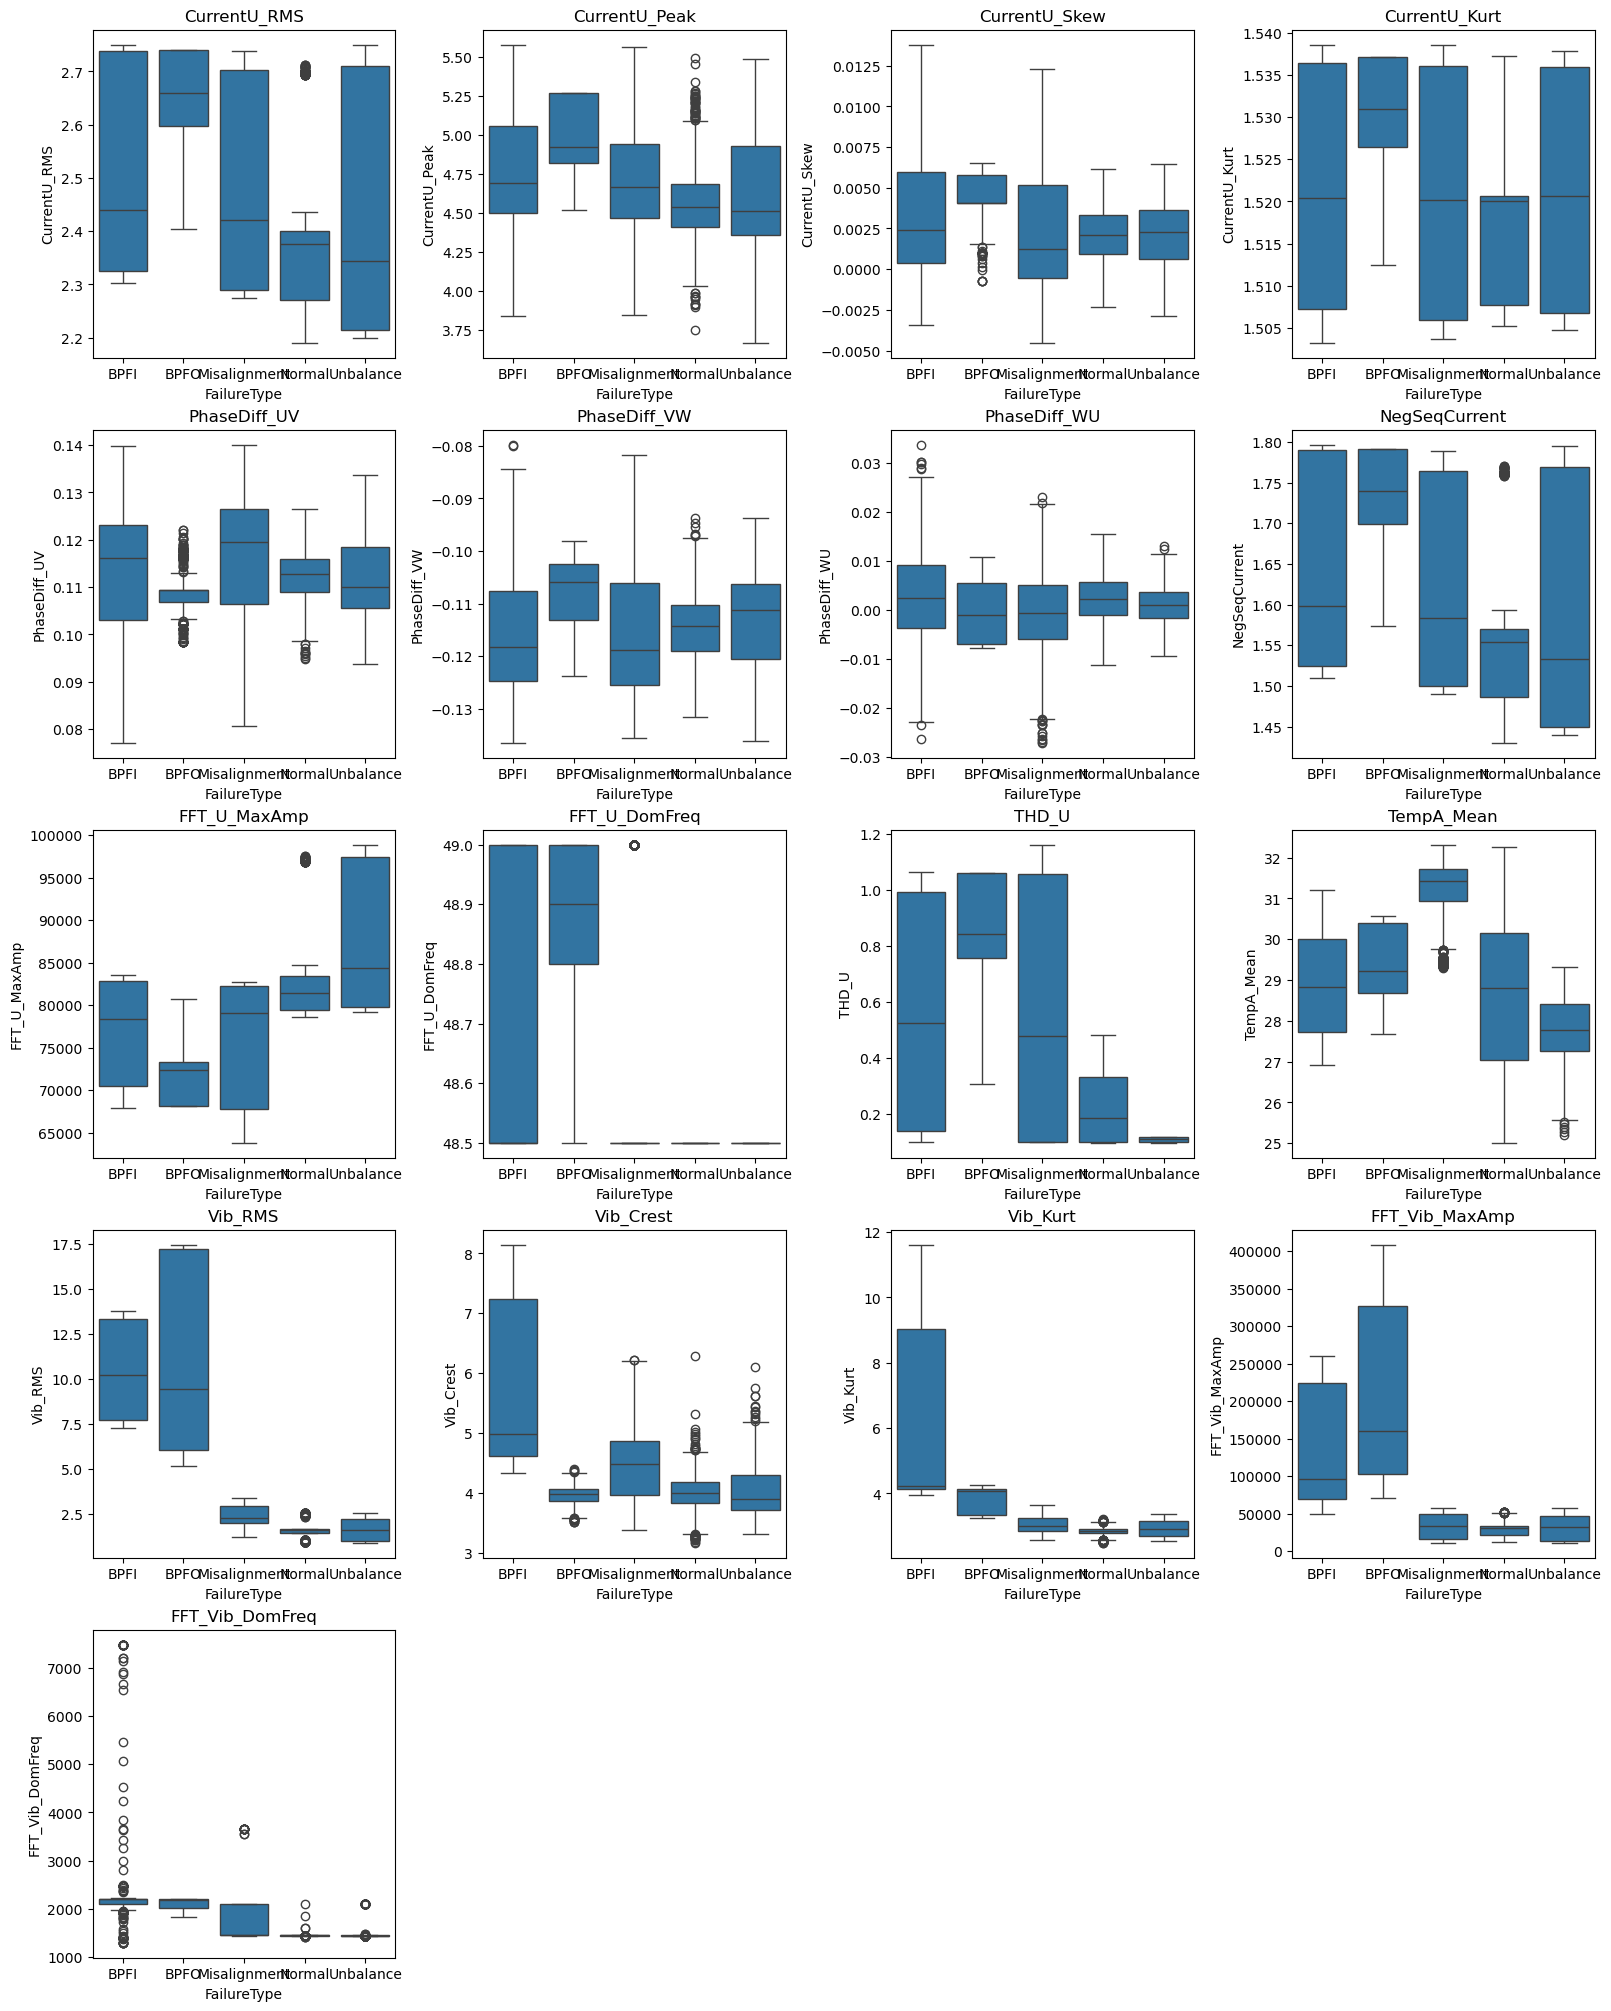

In [21]:
feature_cols = [col for col in df_smoted.columns if col != 'FailureType']
n_features = len(feature_cols)
n_cols = 4
n_rows = int(np.ceil(n_features / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows), constrained_layout=True)
axes = axes.flatten()

for i, col in enumerate(feature_cols):
    sns.boxplot(x='FailureType', y=col, data=df_smoted, ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('FailureType')
    axes[i].set_ylabel(col)

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.show()

In [22]:
# 7. Model Evaluation Across Imputation Methods
scorers = {
    'Accuracy': 'accuracy',
    'F1': 'f1_macro',
    'Precision': 'precision_macro',
    'Recall': 'recall_macro'
}
model = RandomForestClassifier(random_state=42)
results = []
for key, df in smote_results.items():
    X = df.drop(columns=['FailureType'])
    y = df['FailureType']
    row = {'Imputation': key}
    for metric_name, scorer in scorers.items():
        score = cross_val_score(model, X, y, cv=5, scoring=scorer).mean()
        row[metric_name] = score
    results.append(row)
results_df = pd.DataFrame(results)
print(results_df)

  Imputation  Accuracy        F1  Precision    Recall
0       zero  0.957111  0.953691   0.967353  0.957111
1       mean  0.965333  0.961724   0.972247  0.965333
2     median  0.965333  0.961724   0.972247  0.965333
3        knn  0.956444  0.954747   0.965193  0.956444


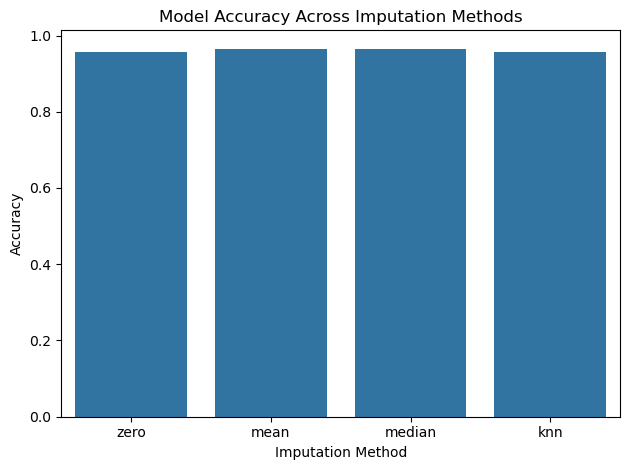

In [23]:
sns.barplot(data=results_df, x='Imputation', y='Accuracy')
plt.title('Model Accuracy Across Imputation Methods')
plt.ylabel('Accuracy')
plt.xlabel('Imputation Method')
plt.tight_layout()
plt.show()

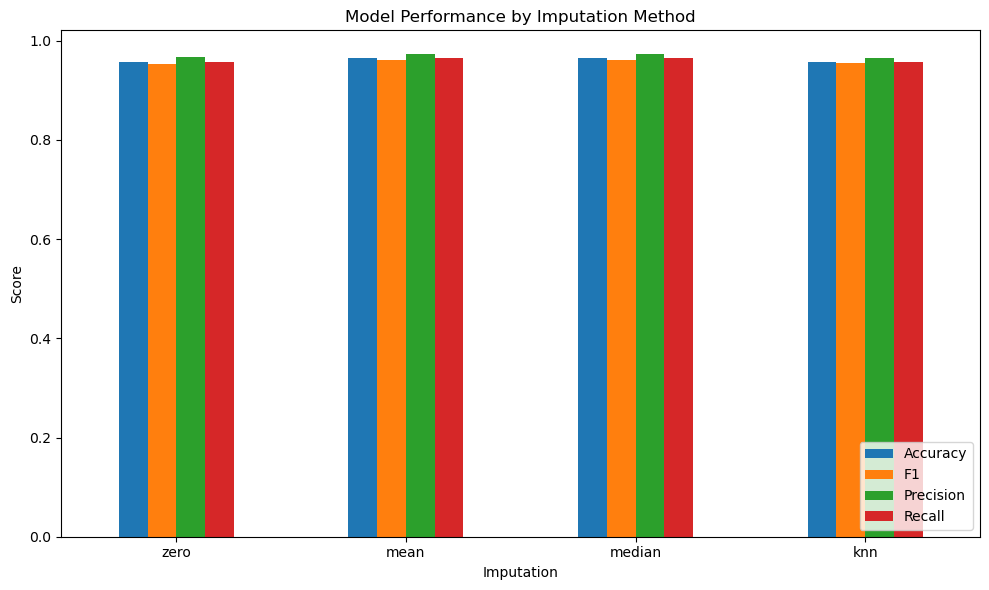

In [24]:
# Plot comparison
results_df.set_index('Imputation').plot(kind='bar', figsize=(10, 6))
plt.title('Model Performance by Imputation Method')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# 6. Feature Selection

In [25]:
# 8. Feature Selection
from sklearn.model_selection import StratifiedKFold


imputation_scores = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf = RandomForestClassifier(random_state=42)
for key, df in smote_results.items():
    X = df.drop(columns=['FailureType'])
    y = df['FailureType']
    X = pd.get_dummies(X, drop_first=True)
    scores = cross_val_score(rf, X, y, cv=cv, scoring='f1_macro')
    imputation_scores[key] = scores.mean()

best_method = max(imputation_scores, key=imputation_scores.get)
best_df = smote_results[best_method]
rf.fit(best_df.drop(columns=['FailureType']), best_df['FailureType'])
importances = pd.Series(rf.feature_importances_, index=best_df.drop(columns=['FailureType']).columns)
top_features = importances[importances > 0.02].index.tolist()
X_filtered = best_df[top_features]
y_filtered = best_df['FailureType']


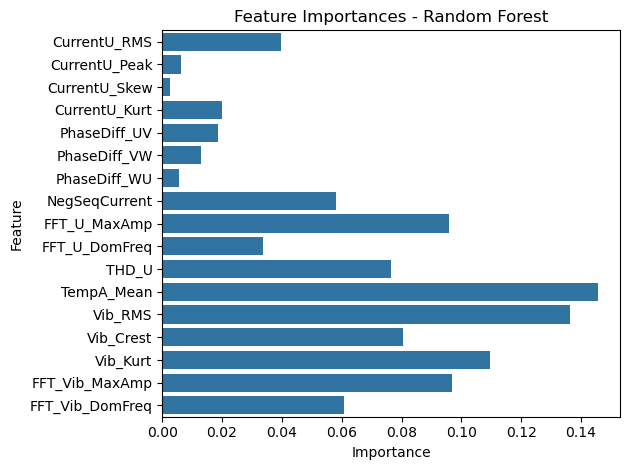

In [26]:
# Feature Importance Plot
sns.barplot(x=importances, y=best_df.drop(columns=['FailureType']).columns)
plt.title('Feature Importances - Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [27]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf = RandomForestClassifier(random_state=42)

imputation_scores = {}

for key, df in smote_results.items():
    X = df.drop(columns=['FailureType'])
    y = df['FailureType']
    
    # Encode if needed
    X = pd.get_dummies(X, drop_first=True)
    
    scores = cross_val_score(rf, X, y, cv=cv, scoring='f1_macro')
    imputation_scores[key] = scores.mean()

# 7. Model Training & Tuning

In [28]:
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(kernel='rbf', random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}
final_scores = {}
for name, model in models.items():
    scores = cross_val_score(model, X_filtered, y_filtered, cv=cv, scoring='f1_macro')
    final_scores[name] = scores.mean()
print("Best Imputation:", best_method)
print("Selected Features:", top_features)
print("Model Comparison:")
print(final_scores)

Best Imputation: mean
Selected Features: ['CurrentU_RMS', 'NegSeqCurrent', 'FFT_U_MaxAmp', 'FFT_U_DomFreq', 'THD_U', 'TempA_Mean', 'Vib_RMS', 'Vib_Crest', 'Vib_Kurt', 'FFT_Vib_MaxAmp', 'FFT_Vib_DomFreq']
Model Comparison:
{'Random Forest': np.float64(0.9986666460900586), 'SVM': np.float64(0.7163619566212911), 'Decision Tree': np.float64(0.9957775497035672)}


In [29]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Random Forest with 100 trees and max_depth=10
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_scores = cross_val_score(rf, X_filtered, y_filtered, cv=cv, scoring='f1_macro')

# SVM with RBF kernel
svm = SVC(kernel='rbf', random_state=42)
svm_scores = cross_val_score(svm, X_filtered, y_filtered, cv=cv, scoring='f1_macro')

# Decision Tree with Gini criterion
dt = DecisionTreeClassifier(criterion='gini', random_state=42)
dt_scores = cross_val_score(dt, X_filtered, y_filtered, cv=cv, scoring='f1_macro')

print("Random Forest F1 (mean):", rf_scores.mean())
print("SVM F1 (mean):", svm_scores.mean())
print("Decision Tree F1 (mean):", dt_scores.mean())

Random Forest F1 (mean): 0.9988888734563535
SVM F1 (mean): 0.7163619566212911
Decision Tree F1 (mean): 0.9957775497035672


# 8. Model evaluation

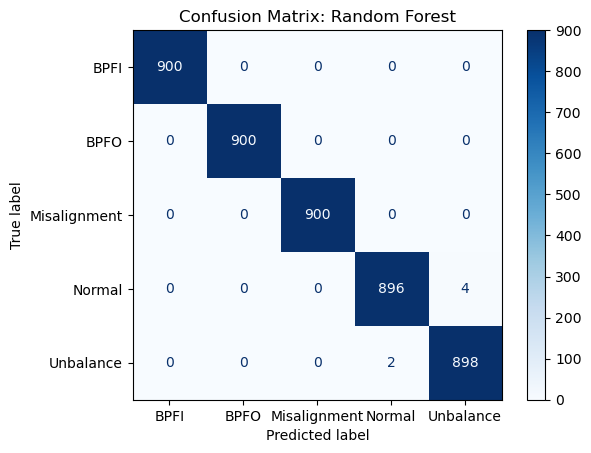

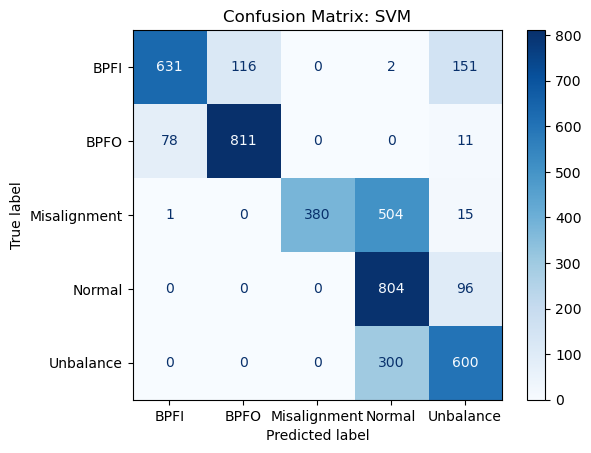

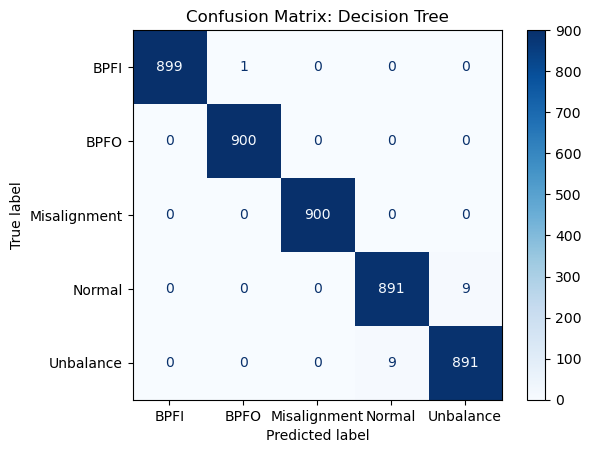

               Accuracy  Precision    Recall  F1-score
Random Forest  0.998667   0.998668  0.998667  0.998667
SVM            0.716889   0.790052  0.716889  0.716570
Decision Tree  0.995778   0.995778  0.995778  0.995778


In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
results = {}

for name, model in models.items():
    y_true_all = []
    y_pred_all = []
    for train_idx, test_idx in cv.split(X_filtered, y_filtered):
        X_train, X_test = X_filtered.iloc[train_idx], X_filtered.iloc[test_idx]
        y_train, y_test = y_filtered.iloc[train_idx], y_filtered.iloc[test_idx]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)
    results[name] = {
        'Accuracy': accuracy_score(y_true_all, y_pred_all),
        'Precision': precision_score(y_true_all, y_pred_all, average='macro'),
        'Recall': recall_score(y_true_all, y_pred_all, average='macro'),
        'F1-score': f1_score(y_true_all, y_pred_all, average='macro')
    }
    cm = confusion_matrix(y_true_all, y_pred_all, labels=np.unique(y_filtered))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_filtered))
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix: {name}')
    plt.show()

print(pd.DataFrame(results).T)

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, recall_score

scorers = {
    'Accuracy': 'accuracy',
    'F1': 'f1_macro',
    'Precision': 'precision_macro',
    'Recall': 'recall_macro'
}

model = RandomForestClassifier(random_state=42)

results = []

for key, df in smote_results.items():
    X = df.drop(columns=['FailureType'])
    y = df['FailureType']

    row = {'Imputation': key}
    for metric_name, scorer in scorers.items():
        score = cross_val_score(model, X, y, cv = 5, scoring = scorer).mean()
        row[metric_name] = score
    results.append(row)